# Modeling - RAG

This notebook include testing of some models until we defined the final one.

Let's remember the strategies:

1. Extractive QA: The answer is a span of text from the context.
    1. In this case we can possible use some kind of retriever in the query and use the model as an extractor for the context. 
    2. The problem with this (at this point) is don't know how good each topic of the dataset is represented in the dataset.
2. Open Generative QA: The answer generated by one of the retrieved options.
    1. Using more complexity (in terms of memory and time) we can use a model to generate the answer. We rely in some pre-trained model knowledge better approach some queries variants.
    2. More complexity, more inference time, possible need GPU and not can generate no safety answer (considering the dataset is composed only by true/safe answers).
3. Generative QA: The answer is a free text.
    1. The same as the open generative QA but not always rely in the retrieved options.


## Libs and Variables

In [84]:
import logging
import random
import re
import warnings

import numpy as np
import pandas as pd
import torch
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DataFrameLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import OllamaEmbeddings
from langchain_ollama import OllamaLLM
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from metrics import compute_metrics
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Remove pandas warning from Sentence Transformers lib
warnings.simplefilter(action="ignore", category=FutureWarning)

# Ollama http logs
logging.getLogger("httpx").setLevel(logging.WARNING)

clean_repeated_ws = lambda text: re.sub(r"\s+", " ", text).strip()

In [85]:
def seed_all():
    """
    Seed all the random number generators to ensure reproducibility.

    This function sets the seed for the Python built-in random module and the NumPy random module to 42.
    This ensures that any random operations performed using these modules will produce the same results
    each time the code is run.
    """
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)


seed_all()

In [86]:
DATA_PATH = "../data/data.csv"

## Load data

In [87]:
data = pd.read_csv(DATA_PATH)

data["question"] = data["question"].astype(str)
data["answer"] = data["answer"].astype(str)

data["question"] = data["question"].apply(clean_repeated_ws)
data["answer"] = data["answer"].apply(clean_repeated_ws)

In [88]:
data.head(5).style

,question,answer
0,What is (are) Glaucoma ?,"Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more. See a glossary of glaucoma terms."
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 million nerve fibers. It connects the retina to the brain.
2,What is (are) Glaucoma ?,"Open-angle glaucoma is the most common form of glaucoma. In the normal eye, the clear fluid leaves the anterior chamber at the open angle where the cornea and iris meet. When the fluid reaches the angle, it flows through a spongy meshwork, like a drain, and leaves the eye. Sometimes, when the fluid reaches the angle, it passes too slowly through the meshwork drain, causing the pressure inside the eye to build. If the pressure damages the optic nerve, open-angle glaucoma -- and vision loss -- may result."
3,Who is at risk for Glaucoma? ?,"Anyone can develop glaucoma. Some people are at higher risk than others. They include - African-Americans over age 40 - everyone over age 60, especially Hispanics/Latinos - people with a family history of glaucoma. African-Americans over age 40 everyone over age 60, especially Hispanics/Latinos people with a family history of glaucoma. See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more."
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent glaucoma. However, studies have shown that the early detection and treatment of glaucoma, before it causes major vision loss, is the best way to control the disease. So, if you fall into one of the higher risk groups for the disease, make sure to have a comprehensive dilated eye exam at least once every one to two years. Get tips on finding an eye care professional. Learn what a comprehensive dilated eye exam involves."


## Data split

In [89]:
# DEVELOPMENT
data = data.head(10000)

# split train test val (90-5-5)
train, test = train_test_split(data, test_size=0.9, random_state=42, shuffle=True)
val, test = train_test_split(test, test_size=0.5, random_state=42, shuffle=True)

# use 10% of test to be around 5 min considering llama3.2:1b
test = test.sample(frac=0.025, random_state=42)

In [90]:
test.shape

(112, 2)

## Testing some techniques

In [91]:
_llm = OllamaLLM(model="llama3.2:1b", temperature=0)

In [92]:
loader = DataFrameLoader(train, page_content_column="question")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=150, chunk_overlap=50)


splits = text_splitter.split_documents(docs)

embeddings_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embed = HuggingFaceEmbeddings(model_name=embeddings_model_name)

vectorstore_questions = FAISS.from_documents(documents=splits, embedding=embed)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


### Multiquery

In [93]:
sample = "What is cataract?"
threshold = 0.1

res = vectorstore_questions.similarity_search_with_relevance_scores(
    sample,
    k=3,
)

filtered_res = list(filter(lambda x: x[1] > threshold, res))

[(doc[0].page_content, doc[1]) for doc in filtered_res]

[('What is (are) Cataract ?', np.float32(0.83214307)),
 ('What are the symptoms of Cataract ?', np.float32(0.55580974)),
 ('What is (are) Macular degeneration ?', np.float32(0.30216485))]

In [94]:
prompt_multiquery = """
From provided question, return 3 new question trying to specify the context of the question. Separe them by newlines
Answer only the new questions separeted by newlines, without any aditional information.
Question:
{query}
"""

queries = _llm.invoke(prompt_multiquery.format(query=sample)).split("\n")

queries

['1. What causes cataracts in children?',
 '2. How are cataracts diagnosed?',
 '3. What are the symptoms of cataracts?']

In [95]:
results = []
for query in queries:
    res = vectorstore_questions.similarity_search_with_relevance_scores(
        query,
        k=3,
    )

    filtered_res = list(filter(lambda x: x[1] > threshold, res))
    filtered_res = [(doc[0], doc[1].item()) for doc in filtered_res]

    results.append(filtered_res)

    print(filtered_res)

[(Document(metadata={'answer': 'The most common symptoms of a cataract are - cloudy or blurry vision - colors seem faded - glare -- headlights, lamps, or sunlight appearing too bright, or a halo may appear around lights - poor night vision - double vision or multiple images in one eye - frequent prescription changes in your eyeglasses or contact lenses. cloudy or blurry vision colors seem faded glare -- headlights, lamps, or sunlight appearing too bright, or a halo may appear around lights poor night vision double vision or multiple images in one eye frequent prescription changes in your eyeglasses or contact lenses. These symptoms can also be a sign of other eye problems. If you have any of these symptoms, check with your eye care professional.'}, page_content='What are the symptoms of Cataract ?'), 0.5489493012428284), (Document(metadata={'answer': 'National Eye Institute National Institutes of Health 2020 Vision Place Bethesda, MD 20892-3655 301-496-5248 E-mail: 2020@nei.nih.gov www

Rag-fusion test

In [96]:
from langchain.load import dumps, loads

fused_scores = {}
k = 60
for docs in results:
    for rank, doc in enumerate(docs):
        doc_str = dumps(doc)
        if doc_str not in fused_scores:
            fused_scores[doc_str] = 0
        previous_score = fused_scores[doc_str]
        fused_scores[doc_str] += 1 / (rank + k)

reranked_results = [
    (loads(doc), score)
    for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
]

In [97]:
reranked_results

[([Document(metadata={'answer': 'The most common symptoms of a cataract are - cloudy or blurry vision - colors seem faded - glare -- headlights, lamps, or sunlight appearing too bright, or a halo may appear around lights - poor night vision - double vision or multiple images in one eye - frequent prescription changes in your eyeglasses or contact lenses. cloudy or blurry vision colors seem faded glare -- headlights, lamps, or sunlight appearing too bright, or a halo may appear around lights poor night vision double vision or multiple images in one eye frequent prescription changes in your eyeglasses or contact lenses. These symptoms can also be a sign of other eye problems. If you have any of these symptoms, check with your eye care professional.'}, page_content='What are the symptoms of Cataract ?'),
   0.5489493012428284],
  0.016666666666666666),
 ([Document(metadata={'answer': 'The most common symptoms of a cataract are - cloudy or blurry vision - colors seem faded - glare -- headl

### Different flows to question x answer x non-context (HyDE like generation)

Let's make some discussoes about the flows:

If we match directly the question with high similarity score, that's the best case. Only need to give the retrieved docs to the model (maybe look to context size).

As a feature of the dataset, we have more information in the answers than in the questions. The user question can be mo involved in part of the answer. In case when we don't match any question, I'll try to match some chunk of answer.

If no one match occurs, we rely in open generation. That point can be covered by guardrails or maybe be a point of "No answer" to the user.

In [98]:
train

,question,answer
6490,What are the treatments for Progressive transf...,What treatment is available for progressive tr...
8609,How to diagnose Heart Palpitations ?,"First, your doctor will want to find out wheth..."
9978,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...
8070,How to diagnose Parasites - Schistosomiasis ?,Stool or urine samples can be examined microsc...
8577,Who is at risk for Iron-Deficiency Anemia? ?,Infants and Young Children Infants and young c...
...,...,...
5734,What causes Relapsing polychondritis ?,What causes relapsing polychondritis? The exac...
5191,What is (are) Leprechaunism ?,Leprechaunism is a congenital (present from bi...
5390,What are the treatments for Hallermann-Streiff...,How might Hallermann-Streiff syndrome be treat...
860,What are the stages of Uterine Sarcoma ?,Key Points - After uterine sarcoma has been di...


In [99]:
train["complete_answer"] = train["answer"]

In [111]:
loader = DataFrameLoader(train, page_content_column="answer")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=128, chunk_overlap=64)


splits = text_splitter.split_documents(docs)

In [112]:
random.seed(42)
random.sample(splits, 3)

[Document(metadata={'question': 'What are the treatments for Childhood Central Nervous System Embryonal Tumors ?', 'complete_answer': "Key Points - There are different types of treatment for children who have central nervous system (CNS) embryonal tumors. - Children who have CNS embryonal tumors should have their treatment planned by a team of health care providers who are experts in treating brain tumors in children. - Childhood brain tumors may cause signs or symptoms that begin before the cancer is diagnosed and continue for months or years. - Some cancer treatments cause side effects months or years after treatment has ended. - Five types of treatment are used: - Surgery - Radiation therapy - Chemotherapy - High-dose chemotherapy with stem cell rescue - Targeted therapy - New types of treatment are being tested in clinical trials. - Patients may want to think about taking part in a clinical trial. - Patients can enter clinical trials before, during, or after starting their cancer t

In [113]:
embeddings_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embed = HuggingFaceEmbeddings(model_name=embeddings_model_name)

vectorstore_answers = FAISS.from_documents(documents=splits, embedding=embed)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


In [114]:
sample = "three genes (HESX1, OTX2, and SOX2) have been associated to some disease?"

print("Retrieve from questions:")
res = vectorstore_questions.similarity_search_with_relevance_scores(sample, k=3)
for i in res:
    print(i[0].page_content, i[1])
print()
print("Retrieve from answers:")
res = vectorstore_answers.similarity_search_with_relevance_scores(sample, k=3)
for i in res:
    print(i[0].metadata["question"])
    print(i[0].page_content[:100], i[1])
    print()

Retrieve from questions:
Is Castleman disease inherited ? 0.30561018
What is (are) Waardenburg syndrome type 2 ? 0.30231
Is Danon disease inherited ? 0.29219258

Retrieve from answers:
What is (are) Septo-optic dysplasia ?
(HESX1, OTX2, and SOX2) have been associated with septo-optic dysplasia. Typically, people do not ha 0.51054955

Who is at risk for Prostate Cancer? ?
of families who have several members with the disease. Other studies are trying to identify which ge 0.4813087

What is (are) Familial prostate cancer ?
HOXB13, or several other genes. Other cases are likely due to a combination of gene(s) and other sha 0.44659787



### Retrieval summarization

Some answer can have more than 5k of tokens. We can use some summarization technique to reduce the size of the answer.

In the real life scenario it's interestig to pre-compute and add to our dataset. In my rushed scenario about the deadline, I'll put that on the inferece.

In [120]:
import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")

In [122]:
train["answer_tokens"] = train["answer"].apply(lambda i: len(tokenizer.encode(i)))

<Axes: ylabel='Frequency'>

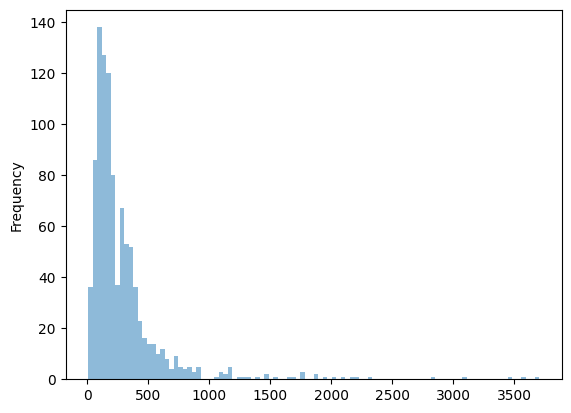

In [151]:
train["answer_tokens"].plot.hist(bins=100, alpha=0.5)

In [124]:
train.sort_values("answer_tokens", ascending=False).head(5)

,question,answer,complete_answer,answer_tokens
1267,What are the treatments for Childhood Central ...,Key Points - There are different types of trea...,Key Points - There are different types of trea...,3704
1167,What are the treatments for Prostate Cancer ?,Key Points - There are different types of trea...,Key Points - There are different types of trea...,3560
1484,What are the treatments for Langerhans Cell Hi...,Key Points - There are different types of trea...,Key Points - There are different types of trea...,3474
853,What are the treatments for Childhood Extracra...,Key Points - There are different types of trea...,Key Points - There are different types of trea...,3104
1081,What are the treatments for Bile Duct Cancer (...,Key Points - There are different types of trea...,Key Points - There are different types of trea...,2831


In [126]:
long_sample = train.sort_values("answer_tokens", ascending=False).iloc[0]["answer"]

Take around 30s to summarize one sample

In [127]:
prompt = """
Summarize the following text in 100 words. Answer only the summarization, without any aditional information.

Text:
{sample}
"""

summary = _llm.invoke(prompt.format(sample=long_sample))

In [128]:
summary

"The text appears to be a summary of cancer treatment options and clinical trials for children with medulloepithelioma, pineoblastoma, and recurrent CNS embryonal tumors and pineoblastomas. Here are some key points:\n\n**Medulloepithelioma:**\n\n* The tumor itself has not been treated.\n* Treatment may include surgery to remove as much of the tumor as possible, followed by radiation therapy to the brain and spinal cord, and chemotherapy.\n* Clinical trials for new combinations of radiation therapy and chemotherapy are being explored.\n\n**Pineoblastoma:**\n\n* The tumor itself has not been treated.\n* Treatment may include surgery to remove the tumor, followed by radiation therapy to the brain and spinal cord, and chemotherapy.\n* Clinical trials for high-dose chemotherapy after radiation therapy and stem cell rescue, as well as chemotherapy during radiation therapy, are being explored.\n\n**Recurrent CNS Embryonal Tumors and Pineoblastomas:**\n\n* Treatment depends on the type of tumo

Let's take other way, chunk -> extented_chunk match.

About the positional information bias, we can consider if we match some part of a chunk, use around information (consider overlap) can be better than only use open generation.

In [133]:
_train = train.copy()

new_train = pd.DataFrame(
    

In [131]:
loader = DataFrameLoader(train, page_content_column="complete_answer")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=128, chunk_overlap=64)


splits = text_splitter.split_documents(docs)

In [137]:
_train.iloc[0]

question           What are the treatments for Progressive transf...
answer             What treatment is available for progressive tr...
complete_answer    What treatment is available for progressive tr...
answer_tokens                                                     96
Name: 6490, dtype: object

Testing semantic chunking, but still like 2.5s/sample.
For now, I think that's ok because the number of sample with more than 5k tokens is low. Let's keep all

In [150]:
train[train["answer_tokens"] > 512].shape

(123, 4)

In [145]:
from langchain_experimental.text_splitter import SemanticChunker

embeddings_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embed = HuggingFaceEmbeddings(model_name=embeddings_model_name)


def chunk_answers(answer):
    text_splitter = SemanticChunker(embed, breakpoint_threshold_type="percentile")
    # text_splitter = RecursiveCharacterTextSplitter(chunk_size=256, chunk_overlap=64)
    return [i.page_content for i in text_splitter.create_documents([answer])]


long_sample_chunked = chunk_answers(long_sample)

print(long_sample_chunked)

list(map(lambda i: len(tokenizer.encode(i)), long_sample_chunked))

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


['Key Points - There are different types of treatment for children who have central nervous system (CNS) embryonal tumors. - Children who have CNS embryonal tumors should have their treatment planned by a team of health care providers who are experts in treating brain tumors in children. - Childhood brain tumors may cause signs or symptoms that begin before the cancer is diagnosed and continue for months or years. - Some cancer treatments cause side effects months or years after treatment has ended. - Five types of treatment are used: - Surgery - Radiation therapy - Chemotherapy - High-dose chemotherapy with stem cell rescue - Targeted therapy - New types of treatment are being tested in clinical trials. - Patients may want to think about taking part in a clinical trial. - Patients can enter clinical trials before, during, or after starting their cancer treatment. - Follow-up tests may be needed. There are different types of treatment for children who have central nervous system (CNS) 

[431, 134, 100, 926, 565, 686, 96, 226, 266, 22, 253]

In [152]:
train["answer_chunks"] = train["answer"].apply(chunk_answers)

In [154]:
train

,question,answer,complete_answer,answer_tokens,answer_chunks
6490,What are the treatments for Progressive transf...,What treatment is available for progressive tr...,What treatment is available for progressive tr...,96,[What treatment is available for progressive t...
8609,How to diagnose Heart Palpitations ?,"First, your doctor will want to find out wheth...","First, your doctor will want to find out wheth...",873,"[First, your doctor will want to find out whet..."
9978,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...,Mutations in the ARSB gene cause MPS VI. The A...,220,[Mutations in the ARSB gene cause MPS VI. The ...
8070,How to diagnose Parasites - Schistosomiasis ?,Stool or urine samples can be examined microsc...,Stool or urine samples can be examined microsc...,81,[Stool or urine samples can be examined micros...
8577,Who is at risk for Iron-Deficiency Anemia? ?,Infants and Young Children Infants and young c...,Infants and Young Children Infants and young c...,674,[Infants and Young Children Infants and young ...
...,...,...,...,...,...
5734,What causes Relapsing polychondritis ?,What causes relapsing polychondritis? The exac...,What causes relapsing polychondritis? The exac...,211,[What causes relapsing polychondritis? The exa...
5191,What is (are) Leprechaunism ?,Leprechaunism is a congenital (present from bi...,Leprechaunism is a congenital (present from bi...,85,[Leprechaunism is a congenital (present from b...
5390,What are the treatments for Hallermann-Streiff...,How might Hallermann-Streiff syndrome be treat...,How might Hallermann-Streiff syndrome be treat...,270,[How might Hallermann-Streiff syndrome be trea...
860,What are the stages of Uterine Sarcoma ?,Key Points - After uterine sarcoma has been di...,Key Points - After uterine sarcoma has been di...,1537,[Key Points - After uterine sarcoma has been d...


In [155]:
train[["question", "answer_chunks"]].explode("answer_chunks")

,question,answer_chunks
6490,What are the treatments for Progressive transf...,What treatment is available for progressive tr...
6490,What are the treatments for Progressive transf...,Affected individuals should have regular follo...
8609,How to diagnose Heart Palpitations ?,"First, your doctor will want to find out wheth..."
8609,How to diagnose Heart Palpitations ?,How often do they occur? Do they start and sto...
8609,How to diagnose Heart Palpitations ?,Do they happen at a certain time of day? Your ...
...,...,...
860,What are the stages of Uterine Sarcoma ?,"Uterine sarcoma may be diagnosed, staged, and ..."
860,What are the stages of Uterine Sarcoma ?,Sometimes organs are removed or tissue samples...
860,What are the stages of Uterine Sarcoma ?,"For a regional lymphadenectomy, some of the ly..."
7270,What are the treatments for Thalassemia ?,How might thalassemia be treated?


## RAG

### Vector Database

In [115]:
loader = DataFrameLoader(train, page_content_column="question")
docs = loader.load()

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=150, chunk_overlap=50)


splits = text_splitter.split_documents(docs)

In [10]:
# embed = OllamaEmbeddings(model="llama3.2:3b")
embeddings_model_name = "sentence-transformers/all-MiniLM-L6-v2"


embed = HuggingFaceEmbeddings(model_name=embeddings_model_name)


vectorstore_questions = FAISS.from_documents(documents=splits, embedding=embed)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:faiss.loader:Loading faiss with AVX512 support.
INFO:faiss.loader:Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.


In [11]:
# LLM
llm = ChatOllama(model="llama3.2:1b", temperature=0)

# Prompt
system_message = """
You are a medical assistant AI Bot oriented by document search.
You answer need to be based on the provivided context, you don't need to specify how you answer to the user.
If you don't have certain about the answer, please let the user know and don't try to guess.
"""

prompt = """
Answer the provided question based on the retrieved documments.

Question:
{query}

Context:
{context}

Answer:
"""

template = ChatPromptTemplate([("system", system_message), ("human", prompt), a])

### Define the flow

In [12]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain

import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")


class State(TypedDict):
    query: str
    context: List[Document]
    answer: str
    threshold: float

def multiquery(state: State):

def retrieve(state: State):

    retrieved_docs = vectorstore_questions.similarity_search_with_relevance_scores(
        state["query"], k=3
    )

    filtered_retrieved = list(
        filter(lambda x: x[1] > state["threshold"], retrieved_docs)
    )

    return {"context": filtered_retrieved}


def generate(state: State):

    docs_content = "\n\n".join(doc.metadata["answer"] for doc in state["context"])

    messages = template.invoke({"query": state["query"], "context": docs_content})

    # print(" ---------- PROMPT ----------")
    # for i in messages:
    #     for j in i[1]:
    #         print(j.content)
    # print(" ---------- PROMPT ----------")

    response = llm.invoke(messages)

    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

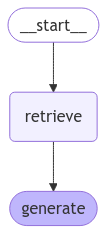

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
question = train.iloc[0].question
answer = train.iloc[0].answer

print(f"Question: {question}\n")
print(f"True Answer: {answer}\n")

inference = graph.invoke({"query": question, "thershold": 0.7})

print(f"Model Answer: \n{inference['answer'].content}")

Question: What are the symptoms of Juvenile osteoporosis ?

True Answer: What are the signs and symptoms of Juvenile osteoporosis? The Human Phenotype Ontology provides the following list of signs and symptoms for Juvenile osteoporosis. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Bone pain 90% Recurrent fractures 90% Reduced bone mineral density 90% Gait disturbance 50% Kyphosis 7.5% Autosomal recessive inheritance - Low serum calcitriol (1,25-dihydroxycholecalciferol) - Osteoporosis - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate 

## Evaluation

In [15]:
for i, row in tqdm(test.iterrows(), total=test.shape[0]):
    question = row.question
    answer = row.answer

    inference = graph.invoke(
        {
            "query": question,
        }
    )

    test.loc[i, "model_answer"] = inference["answer"].content
    test.loc[i, "generation_duration"] = inference["answer"].response_metadata[
        "total_duration"
    ]
    test.loc[i, "generation_n_tokens"] = inference["answer"].response_metadata[
        "eval_count"
    ]

  0%|          | 0/185 [00:00<?, ?it/s]

In [16]:
metrics = compute_metrics(
    test["model_answer"].tolist(), [[i] for i in test["answer"].tolist()]
)


metrics["mean_generation_duration"] = test["generation_duration"].mean() * 1e-9


metrics["mean_generation_n_tokens"] = test["generation_n_tokens"].mean()


metrics["bleu_score"] = metrics["bleu"]["bleu"]


metrics["bertscore_precision"] = np.mean(metrics["bertscore"]["precision"])

metrics["bertscore_recall"] = np.mean(metrics["bertscore"]["recall"])


metrics["bertscore_f1"] = np.mean(metrics["bertscore"]["f1"])

metrics["st_similarities"] = np.mean(metrics["st_similarities"])


del metrics["bleu"]


del metrics["bertscore"]

In [17]:
metrics

{'st_similarities': np.float32(0.893341),
 'mean_generation_duration': np.float64(1.2321680394594596),
 'mean_generation_n_tokens': np.float64(105.52972972972972),
 'bleu_score': 0.014881583553857566,
 'bertscore_precision': np.float64(0.7898838935671626),
 'bertscore_recall': np.float64(0.740426673438098),
 'bertscore_f1': np.float64(0.7622926318967664)}

In [18]:
metrics_csv = pd.DataFrame(metrics, index=[1])

In [19]:
metrics_csv

,st_similarities,mean_generation_duration,mean_generation_n_tokens,bleu_score,bertscore_precision,bertscore_recall,bertscore_f1
1,0.893341,1.232168,105.52973,0.014882,0.789884,0.740427,0.762293


In [20]:
metrics_csv.to_csv(
    f"../results/metrics_rag_{llm.model.replace(':','_')}.csv", index=False
)

In [21]:
test.to_csv(f"../results/test_rag_{llm.model.replace(':','_')}.csv", index=False)

In [22]:
test.head(5).style

,question,answer,model_answer,generation_duration,generation_n_tokens
6890,What are the treatments for Filippi syndrome ?,"How might Filippi syndrome be treated? The treatment of Filippi syndrome is directed toward the specific symptoms that are apparent in each individual. Treatment may require the coordinated efforts of a team of medical professionals who may need to systematically and comprehensively plan an affected child's treatment. These professionals may include pediatricians; physicians who specialize in disorders of the skeleton, joints, muscles, and related tissues (orthopedists); and/or other health care professionals. In some affected individuals, treatment may include surgical repair of certain skeletal or other abnormalities associated with the disorder. The surgical procedures performed will depend upon the severity of the abnormalities, their associated symptoms, and other factors.","The treatments for Filippi syndrome are: 1. Low-dose aspirin 2. Warfarin (for individuals who have already had a stroke or experience recurrent clots) The recommended treatment for Peters plus syndrome is: 1. Eye examination 2. Growth hormone testing 3. Developmental assessment 4. Regular developmental assessments 5. Agents like corticosteroids should be avoided. For Poland syndrome, the treatments may include: 1. Surgical correction of chest wall deformities (e.g., to improve appearance) 2. Breast reconstruction in females (at the time of normal full breast development)",1202936400.000000,123.000000
2666,What is (are) Kluver Bucy syndrome ?,"Kluver Bucy syndrome is a rare behavioral impairment characterized by inappropriate sexual behaviors and mouthing of objects. Other signs and symptoms, include a diminished ability to visually recognize objects, loss of normal fear and anger responses, memory loss, distractibility, seizures, and dementia. It is associated with damage to the anterior temporal lobes of the brain. Cases have been reported in association with herpes encephalitis and head trauma. Treatment is symptomatic and may include the use of psychotropic medications.",Kluver-Bucy syndrome,276067300.000000,8.000000
6494,What is (are) Chromosome 4q deletion ?,"Chromosome 4q deletion is a chromosome abnormality that affects many different parts of the body. People with this condition are missing genetic material located on the long arm (q) of chromosome 4 in each cell. The severity of the condition and the associated signs and symptoms vary based on the size and location of the deletion and which genes are involved. Common features shared by many people with this deletion include distinctive craniofacial features, skeletal abnormalities, heart defects, intellectual disability, developmental delay, and short stature. Most cases are not inherited, although affected people can pass the deletion on to their children. Treatment is based on the signs and symptoms present in each person.",Chromosome 4q deletion is not mentioned in the provided text.,359862600.000000,15.000000
16155,What causes Hypothyroidism ?,"Hypothyroidism has several causes, including - Hashimotos disease - thyroiditis, or inflammation of the thyroid - congenital hypothyroidism, or hypothyroidism that is present at birth - surgical removal of part or all of the thyroid - radiation treatment of the thyroid - some medications Less commonly, hypothyroidism is caused by too much or too little iodine in the diet or by abnormalities of the pituitary gland. Hashimotos Disease Hashimotos disease, also called chronic lymphocytic thyroiditis, is the most common cause of hypothyroidism in the United States.1 Hashimotos disease is a form of chronic inflammation of the thyroid gland. Hashimotos disease is also an autoimmune disorder. Normally, the immune system protects the body against foreign invaderssuch as viruses and bacteriathat can cause illness. But in autoimmune diseases, the immune system attacks the bodys own cells and organs. With Hashimotos disease, the immune sys